## Resources
- https://www.analyticsvidhya.com/blog/2021/06/nlp-sentiment-analysis/

## import libraries

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc


In [5]:
from sklearn.ensemble import RandomForestClassifier

## import dataset

In [6]:
data_path='sentiment_emotion_data'
for file in os.listdir(data_path):
    print(file)
  

test.txt
train.txt
val.txt


In [7]:
train_path=os.path.join(data_path,'train.txt')
print(train_path)
with open(train_path,'r') as f:
    data=f.readlines()

for i,data in enumerate( data[:10]):
    print(i," : ",data)

sentiment_emotion_data\train.txt
0  :  i didnt feel humiliated;sadness

1  :  i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness

2  :  im grabbing a minute to post i feel greedy wrong;anger

3  :  i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love

4  :  i am feeling grouchy;anger

5  :  ive been feeling a little burdened lately wasnt sure why that was;sadness

6  :  ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise

7  :  i feel as confused about life as a teenager or as jaded as a year old man;fear

8  :  i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy

9  :  i feel romantic too;love



## Convert text file to csv file
- The first part of each line consist of text; the second part is the sentiment of the text.
    i feel romantic too;love

    text='i feel romantic too'
    
    sentiment_label='love'




In [8]:
df_train=pd.read_csv('sentiment_emotion_data/train.txt',sep=';',names=['text','label'])
df_val=pd.read_csv('sentiment_emotion_data/val.txt',sep=';',names=['text','label'])
df_train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


Now, we will concatenate these two data frames, as we will be using cross-validation and we have a separate test dataset, so we don’t need a separate validation set of data. And, then we will reset the index to avoid duplicate indexes.

In [9]:
df=pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


# Visualize and analyze the dataset

In [11]:
print('The sentiment labels are: ',df.label.unique())

The sentiment labels are:  ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


There are six label classes in the dataset, and the distribution of the data is shown in the figure below.

c:\Users\Shimul\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

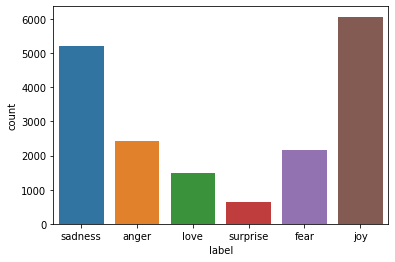

In [12]:
sns.countplot(df.label)

The dataset is a multiclass classification problem for the sentiment analysis task. The dataset is imbalanced. For the simplicity of the task, we will consider the dataset as a binary classification problem and will only consider the positive and negative sentiments.

- positive: joy, love, surprise
- negative: anger, fear, sadness

In [13]:
def custom_encoder(df):
    df['label'].replace(to_replace='surprise',value=0,inplace=True)
    df['label'].replace(to_replace='love',value=0,inplace=True)
    df['label'].replace(to_replace='joy',value=0,inplace=True)
    df['label'].replace(to_replace='sadness',value=1,inplace=True)
    df['label'].replace(to_replace='anger',value=1,inplace=True)
    df['label'].replace(to_replace='fear',value=1,inplace=True)

    return df

binary_df=df
binary_df=custom_encoder(binary_df)
binary_df.head()

,text,label
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,0
4,i am feeling grouchy,1


c:\Users\Shimul\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

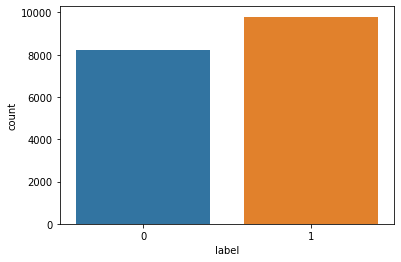

In [14]:
sns.countplot(binary_df.label)

In [15]:
print('The sentiment labels are: ',binary_df.label.unique())

The sentiment labels are:  [1 0]


## Data preprocessing
- lowercase
- remove punctuation
- remove stopwords
- lemmatization


In [16]:
lemmatizer=WordNetLemmatizer()

In [17]:
def text_preprocessing(text):
    corpus=[]
    all_texts=list(text)
    print(all_texts[:5])

    for text in all_texts:
        text=re.sub(r'[^a-zA-Z]',' ',str(text))
        text=text.lower()
        text=text.split()
        text=[lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]        
        corpus.append(' '.join(str(word) for word in text))
    return corpus
corpus=text_preprocessing(binary_df['text'])
print(corpus[:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
['didnt feel humiliated', 'go feeling hopeless damned hopeful around someone care awake', 'im grabbing minute post feel greedy wrong', 'ever feeling nostalgic fireplace know still property', 'feeling grouchy']


## Visualize the word in  Word Cloud
It is a data visualization technique used to depict text in such a way that, the more frequent words appear enlarged as compared to less frequent words. This gives us a little insight into, how the data looks after being processed through all the steps until now.

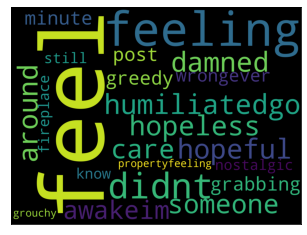

In [18]:

from turtle import back


word_cloud=''
for text in corpus[:5]:
    # print(text)
    for word in text:
        # print(word)
        word_cloud+=" ".join(word)

# print(word_cloud)
wordcloud = WordCloud(width = 2000, height = 1500,min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)
plt.xticks([])
plt.yticks([])  
plt.savefig('sentiment_wordcloud.png',dpi=600)

## Bag of Words
Now, we will use the Bag of Words Model(BOW), which is used to represent the text in the form of a bag of words,i.e. the grammar and the order of words in a sentence are not given any importance, instead, multiplicity,i.e. (the number of times a word occurs in a document) is the main point of concern.

Basically, it describes the total occurrence of words within a document.

Scikit-Learn provides a neat way of performing the bag of words technique using CountVectorizer.

Now, we will convert the text data into vectors, by fitting and transforming the corpus that we have created.

In [19]:
count_vectorizer=CountVectorizer(ngram_range=(1,2))
data=count_vectorizer.fit_transform(corpus)
print(data.shape)

(18000, 117594)


In [20]:
x=data
y=binary_df['label']

## Apply Classifier Model and Tune Hyperparameter using GridSearchCV

In [21]:
parameters={'max_features':('auto','sqrt'),
            'n_estimators':[500,1000,1500],
            'max_depth':[5,10,None],
            'min_samples_split':[5,10,15],
            'min_samples_leaf':[1,2,5,10],
            'bootstrap':[True,False]}
parameters

{'max_features': ('auto', 'sqrt'),
 'n_estimators': [500, 1000, 1500],
 'max_depth': [5, 10, None],
 'min_samples_split': [5, 10, 15],
 'min_samples_leaf': [1, 2, 5, 10],
 'bootstrap': [True, False]}

Now, we will fit the data into the grid search and view the best parameter using the “best_params_” attribute of GridSearchCV.

In [22]:
grid_search= GridSearchCV(RandomForestClassifier(),
                                parameters,
                                cv=5,
                                verbose=2,
                                return_train_score=True,
                                n_jobs=-1)
grid_search.fit(x,y)
grid_search.best_params_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 31.8min
